In [1]:
# import system libs
import os
import itertools
from PIL import Image # pillow

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,BatchNormalization

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = "C:/Users/HP/OneDrive/Desktop/Projects/Weather Classification/Multi-class Weather Dataset"

filepaths = []
labels = []
folds = os.listdir(data_dir) #It prints: ['Cloudy', 'Sunrise', 'Rain', 'Shine']

for fold in folds:
    fold_path= os.path.join(data_dir , fold)
    filelists = os.listdir(fold_path)

    for file in filelists:
        file_path= os.path.join(fold_path , file)

        filepaths.append(file_path)
        labels.append(fold)

#Make & concatenate series & store it in dataframe
Fseries = pd.Series(filepaths, name= "Filepaths")
Lseries = pd.Series(labels, name='Labels')

df = pd.concat([Fseries , Lseries], axis=1)
df.head()

Filepaths  Labels
0  C:/Users/HP/OneDrive/Desktop/Projects/Weather ...  Cloudy
1  C:/Users/HP/OneDrive/Desktop/Projects/Weather ...  Cloudy
2  C:/Users/HP/OneDrive/Desktop/Projects/Weather ...  Cloudy
3  C:/Users/HP/OneDrive/Desktop/Projects/Weather ...  Cloudy
4  C:/Users/HP/OneDrive/Desktop/Projects/Weather ...  Cloudy

In [3]:
Dataset = 'C:/Users/HP/OneDrive/Desktop/Projects/Weather Classification/Multi-class Weather Dataset'

In [4]:
def weather_path(base_path, weather_type):
    '''
    Function to construct the full path of files for a specific weather type.

    Parameters:
        - base_path (str): The base directory path where weather data is stored.
        - weather_type (str): The type of weather ('Cloudy', 'Rain', 'Shine', 'Sunrise').

    Returns:
        - str: The full path to the directory corresponding to the given weather type.
    '''
    # Concatenate the base path with the weather type to form the full path
    full_path = f"{base_path}/{weather_type}"
    return full_path

In [5]:
Cloudy = weather_path(Dataset, 'Cloudy')
Rain = weather_path(Dataset, 'Rain')
Shine = weather_path(Dataset, 'Shine')
Sunrise = weather_path(Dataset, 'Sunrise')

In [6]:
counts=df["Labels"].value_counts()
data=dict(counts)
data

{'Sunrise': 357, 'Cloudy': 300, 'Shine': 253, 'Rain': 215}

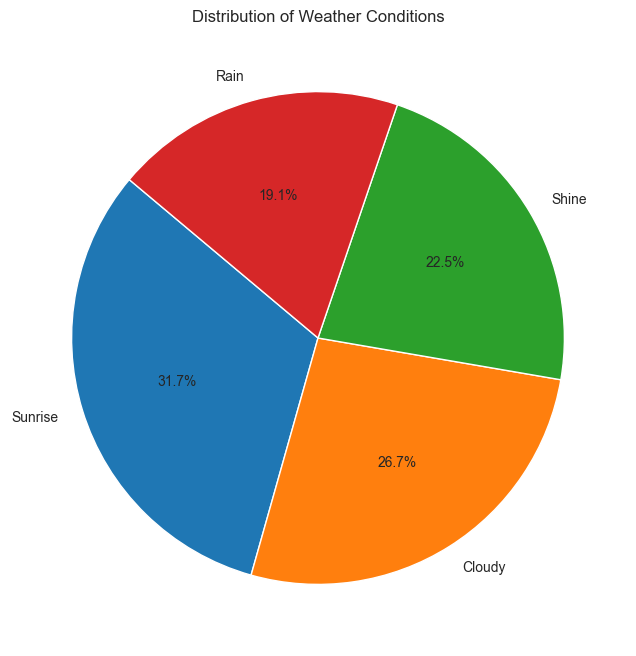

In [7]:
# Extract data for the pie chart
labels = list(data.keys())
sizes = list(data.values())

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Weather Conditions')

# Display the chart
plt.show()

In [8]:
def view_picture(File, weather_type):
    '''
    Function to view a sample of images in a directory with corresponding weather type titles.

    Parameters:
        - File (str): The directory path containing the images.
        - weather_type (str): The type of weather for the images.

    Returns:
        - None
    '''
    # Create a figure with a 3x3 grid of subplots
    plt.figure(figsize=(8, 8))

    # Loop through the first 9 images in the directory
    for i in range(9):
        plt.subplot(3, 3, i + 1)  # Select the next subplot
        image = plt.imread(os.path.join(File, os.listdir(File)[i]))  # Read the image
        plt.imshow(image)  # Display the image
        plt.title(weather_type)  # Set the title to the weather type

    plt.show()  # Show the plot

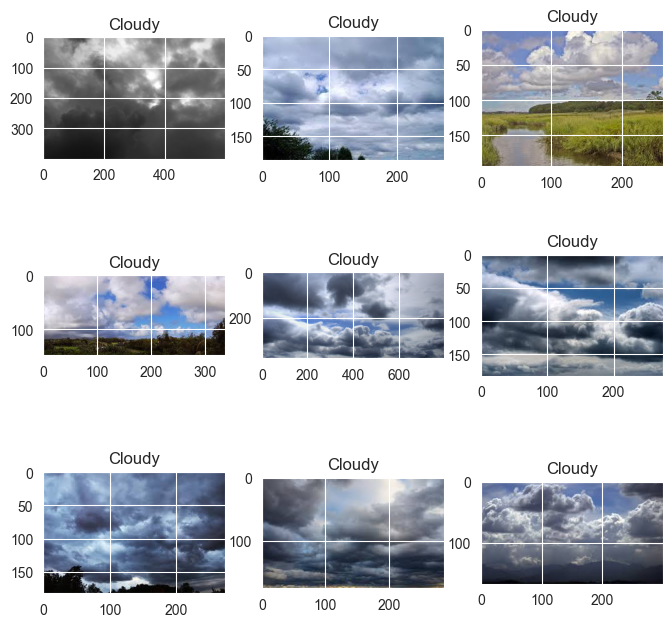

In [9]:
view_picture(Cloudy, "Cloudy")

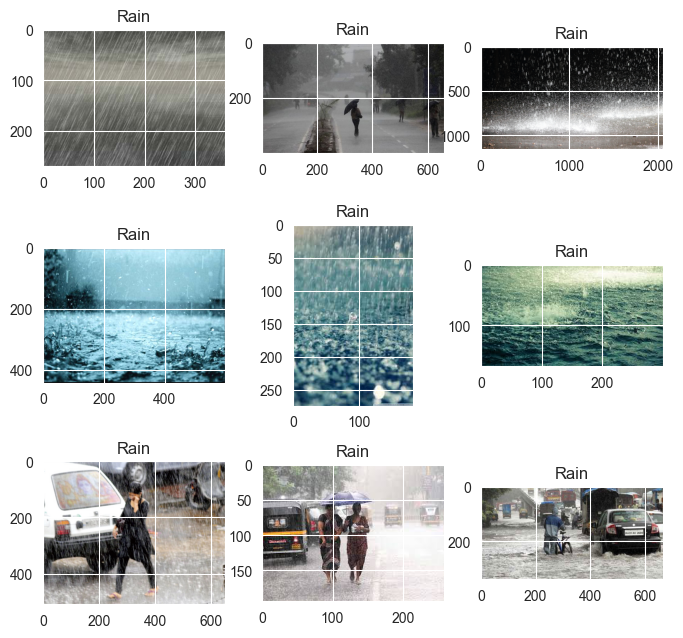

In [10]:
view_picture(Rain, "Rain")

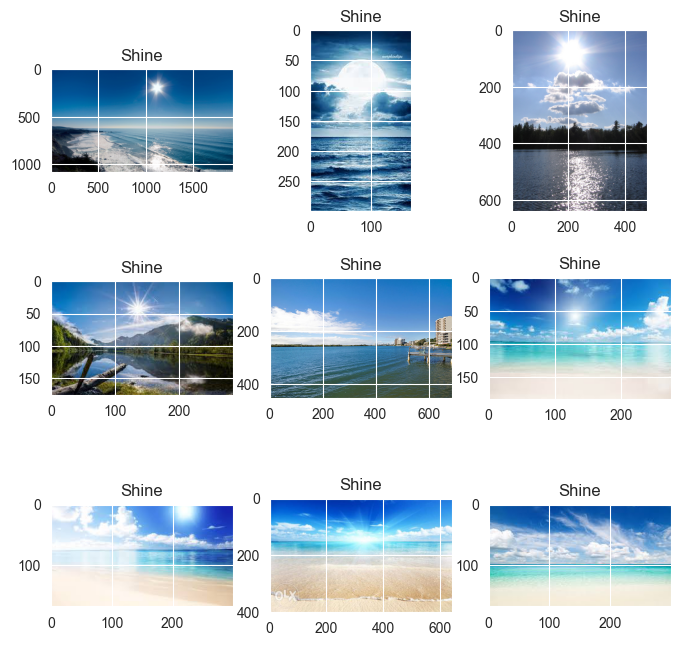

In [11]:
view_picture(Shine, "Shine")

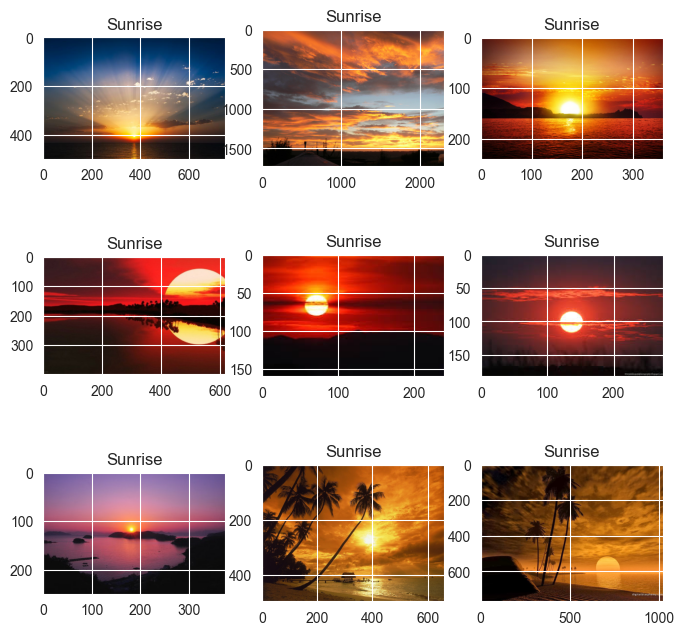

In [12]:
view_picture(Sunrise, "Sunrise")

In [13]:
def create_data_generators(dataset_path, target_size=(250, 250), batch_size=32, validation_split=0.2):
    '''
    Function to create data generators for training and validation.

    Parameters:
        - dataset_path (str): The directory path containing the dataset.
        - target_size (tuple): The dimensions to which all images will be resized.
        - batch_size (int): The batch size for training and validation.
        - validation_split (float): The fraction of the data to use for validation.

    Returns:
        - tuple: A tuple containing the training and validation data generators.
    '''
    # Define the image data generator with specified augmentation parameters
    data_generator = ImageDataGenerator(rescale=1. / 255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        validation_split=validation_split)

    # Create the training data generator
    train_generator = data_generator.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    # Create the validation data generator
    validation_generator = data_generator.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

In [15]:
train_generator, validation_generator = create_data_generators(Dataset, target_size=(250, 250), batch_size=32, validation_split=0.2)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [16]:
def plot_images(images, labels):
    '''
    Function to plot images with corresponding labels.

    Parameters:
        - images (numpy.ndarray): An array of images.
        - labels (numpy.ndarray): An array of labels corresponding to the images.

    Returns:
        - None
    '''
    # Create a figure with a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))

    # Loop through the images and labels to plot them
    for i, ax in enumerate(axes.flat):
        # Display the image
        ax.imshow(images[i])
        ax.axis('off')  # Hide axes
        # Set the title for the subplot with the corresponding label
        ax.set_title(str(labels[i]))  # Convert label to string

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [17]:
images, labels = next(train_generator)

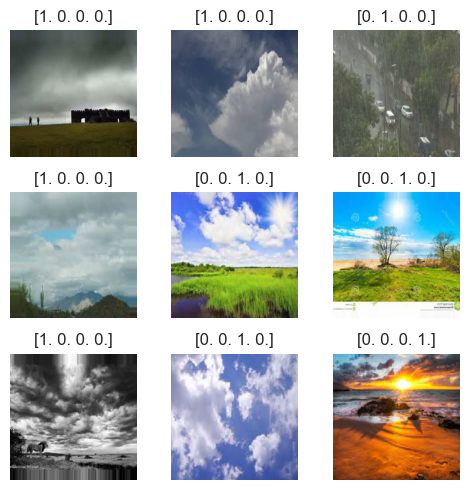

In [18]:
plot_images(images, labels)

In [19]:
from sklearn.model_selection import train_test_split

# Split the data into train and remaining (valid + test)
train_df, remaining_df = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=42)

# Further split the remaining data into validation and test
valid_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['Labels'], random_state=42)

# Verify the split
print(f"Train: {train_df.shape}, Validation: {valid_df.shape}, Test: {test_df.shape}")


Train: (900, 2), Validation: (112, 2), Test: (113, 2)


In [20]:
batch_size= 16
image_size= (224,224)

gen= ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df , x_col='Filepaths' , y_col='Labels'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=True, batch_size=batch_size
                                   ,target_size=image_size)

valid_gen = gen.flow_from_dataframe(valid_df , x_col='Filepaths' , y_col='Labels'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=True, batch_size=batch_size
                                   ,target_size=image_size)

test_gen = gen.flow_from_dataframe(test_df , x_col='Filepaths' , y_col='Labels'
                                   ,class_mode='categorical', color_mode='rgb'
                                   ,shuffle=False, batch_size=batch_size
                                   ,target_size=image_size)

Found 900 validated image filenames belonging to 4 classes.
Found 112 validated image filenames belonging to 4 classes.
Found 113 validated image filenames belonging to 4 classes.


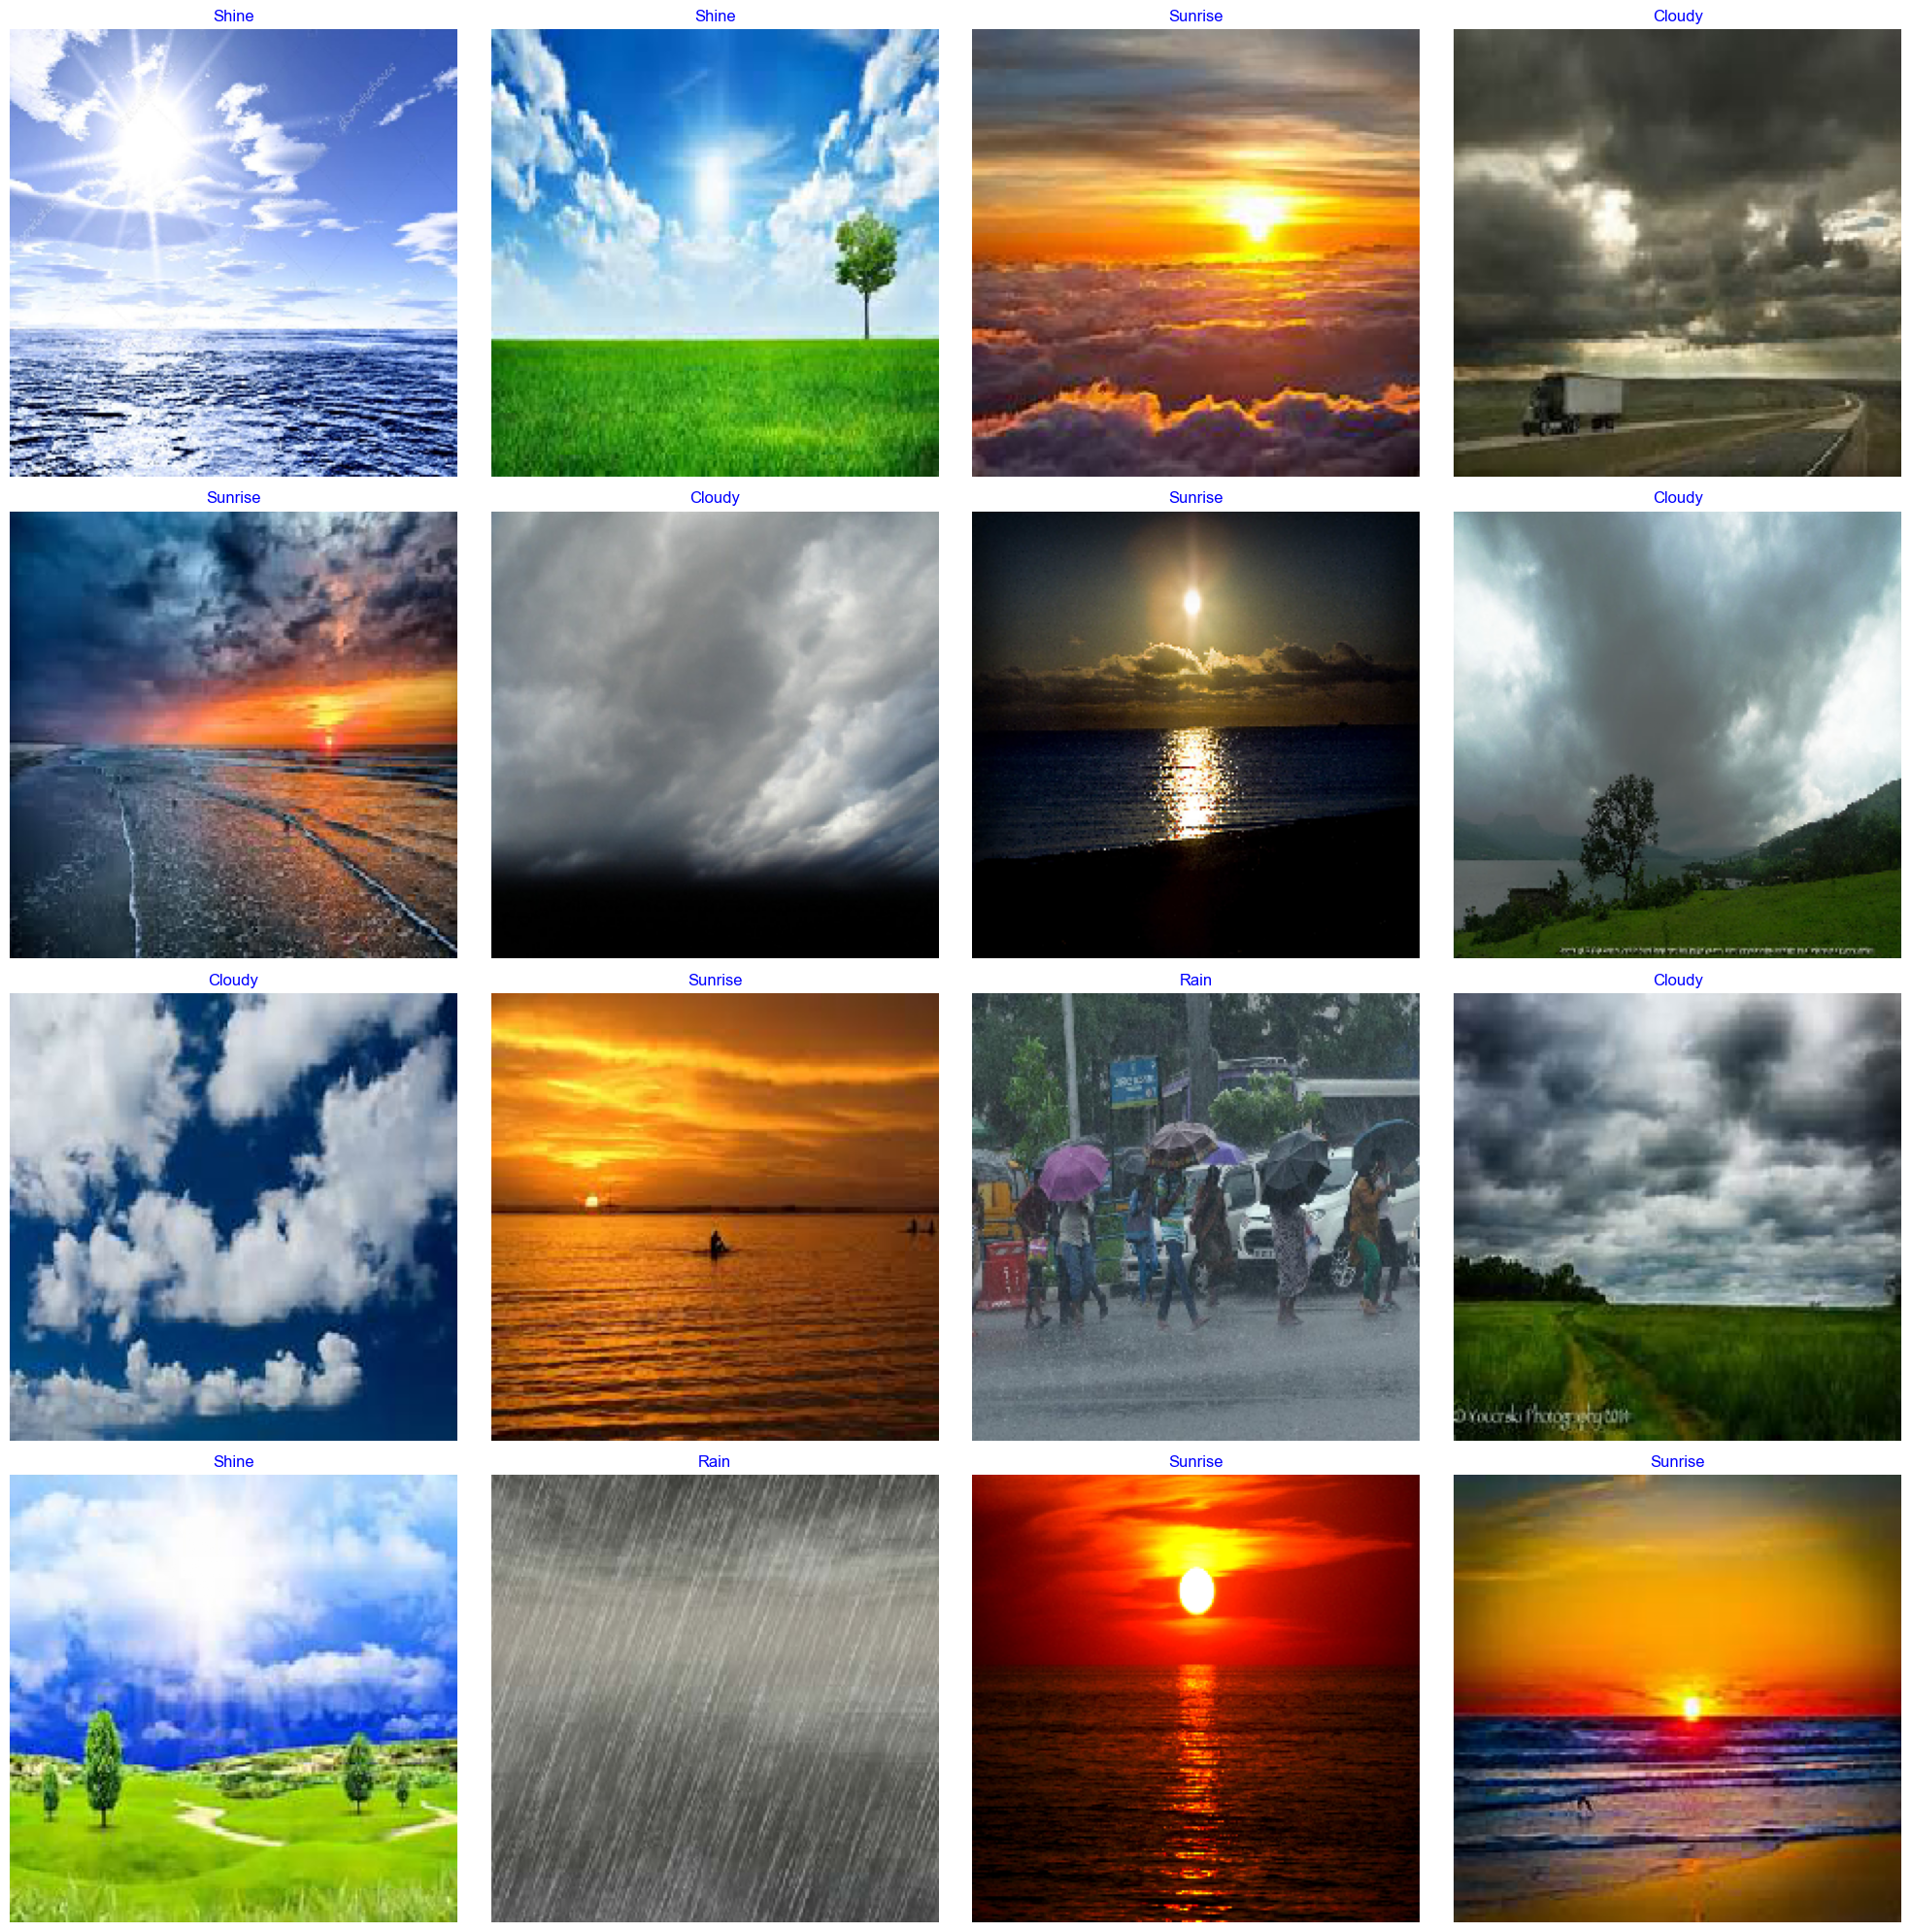

In [21]:
gen_dict = train_gen.class_indices
classes_name = list(gen_dict.keys())

images, labels = next(train_gen)


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes_name[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
channels = 3
image_shape =(image_size[0], image_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu", input_shape=image_shape),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation="softmax")
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,159,268 (99.79 MB)

 Trainable params: 26,158,820 (99.79 MB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
history = model.fit(train_gen, epochs= 10, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.5758 - loss: 9.0911 - val_accuracy: 0.5446 - val_loss: 3.1511
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 368s 6s/step - accuracy: 0.7637 - loss: 1.9512 - val_accuracy: 0.6071 - val_loss: 3.2952
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.8506 - loss: 0.9369 - val_accuracy: 0.8750 - val_loss: 0.6784
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.8747 - loss: 0.4401 - val_accuracy: 0.8571 - val_loss: 0.5328
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 305s 5s/step - accuracy: 0.8729 - loss: 0.5550 - val_accuracy: 0.8661 - val_loss: 0.5074
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.8914 - loss: 0.5305 - val_accuracy: 0.9196 - val_loss: 0.5194
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 378s 6s/step - accuracy: 0.9364 - loss: 0.2812 - val_accuracy: 0.8125 - val_loss: 1.1229
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 374s 6s/step - accuracy: 0.9326 - loss: 0.3163 - val_accuracy: 0.7232 - v

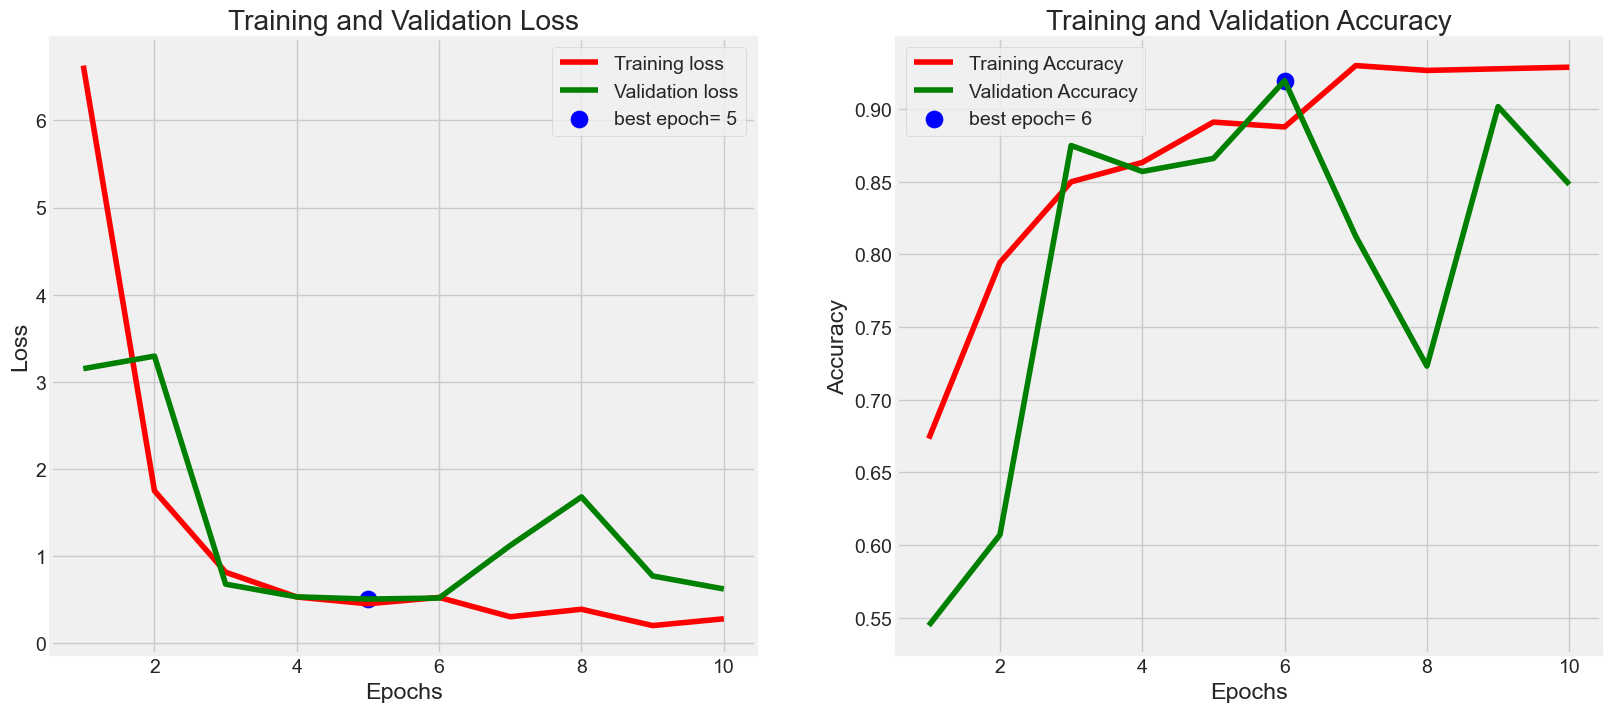

In [25]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [26]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 902ms/step - accuracy: 0.9457 - loss: 0.1359
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 859ms/step - accuracy: 0.8074 - loss: 0.7271
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 801ms/step - accuracy: 0.9258 - loss: 0.2848
Train Loss:  0.16448989510536194
Train Accuracy:  0.9322222471237183
--------------------
Validation Loss:  0.6234172582626343
Validation Accuracy:  0.8482142686843872
--------------------
Test Loss:  0.32223305106163025
Test Accuracy:  0.9292035102844238


In [28]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


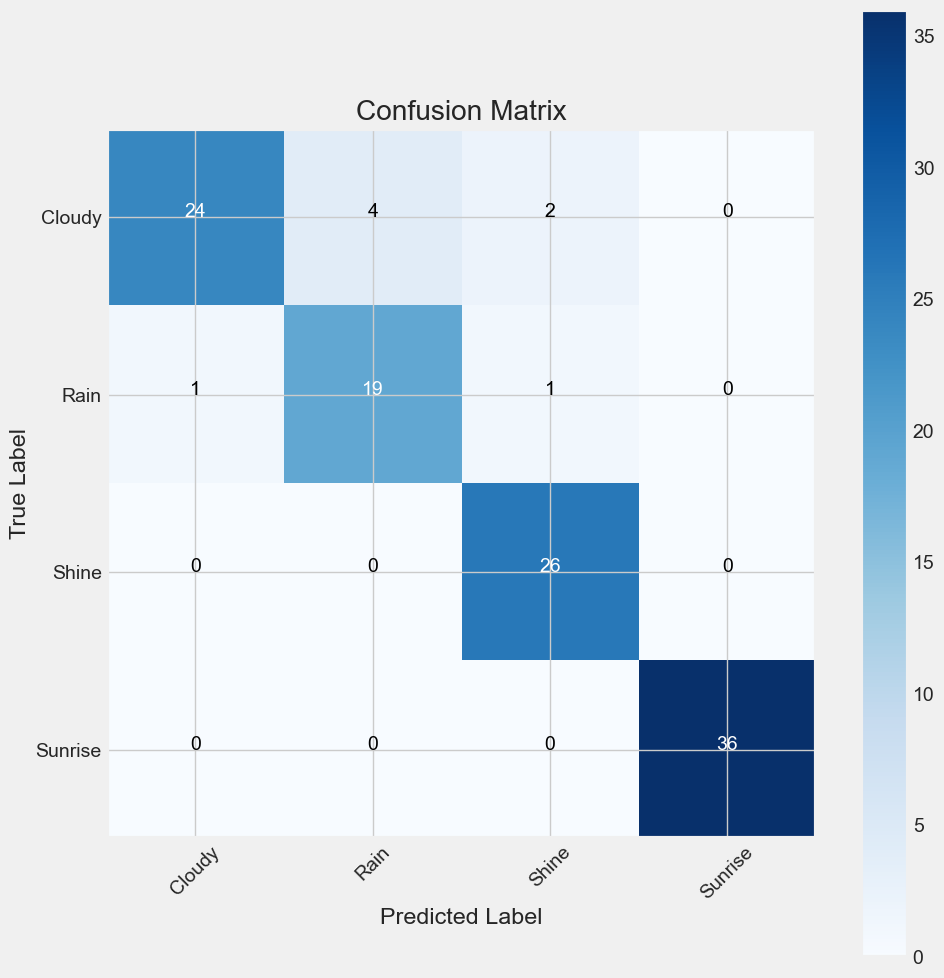

In [29]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [31]:
# Classification report
print(classification_report(test_gen.classes, y_pred,
                            target_names= classes))

              precision    recall  f1-score   support

      Cloudy       0.96      0.80      0.87        30
        Rain       0.83      0.90      0.86        21
       Shine       0.90      1.00      0.95        26
     Sunrise       1.00      1.00      1.00        36

    accuracy                           0.93       113
   macro avg       0.92      0.93      0.92       113
weighted avg       0.93      0.93      0.93       113



In [32]:
#Save the model
model.save('Weather.h5')

In [33]:
loaded_model = tf.keras.models.load_model('C:/Users/HP/OneDrive/Desktop/Projects/Weather Classification/Weather.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy',
                     metrics= ['accuracy'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


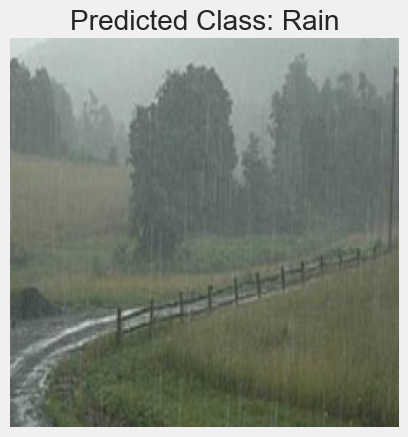

In [35]:
image_path = 'C:/Users/HP/OneDrive/Desktop/Projects/Weather Classification/Multi-class Weather Dataset/Rain/rain28.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
predicted_class = class_labels[np.argmax(predictions)]

# Plot the image with the predicted class label
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()